In [17]:
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

In [18]:
# 分割x and y
def split_x_y(data_train,data_test,target="kredit"):

  train_y = data_train[target]
  train_x = data_train.drop(target, axis=1)

  test_x = data_test.drop(target, axis=1)
  test_y = data_test[target]

  return train_x, train_y, test_x, test_y

# 
def add_id(original_df):
  id = pd.Series(range(0,1000)).apply(lambda i : str(uuid.uuid4()))
  df_with_id = original_df.copy()
  df_with_id['id'] = id
  df_with_id = df_with_id.set_index('id')

  return df_with_id

def split_columns(df_with_id,columns_list,target):
  colum_1 = columns_list.copy()
  colum_1.append(target)
  colum_2 = columns_list.copy()
  # 分割欄位
  client1_data = df_with_id[colum_1]
  client2_data = df_with_id.drop(colum_2, axis=1)

  # 切割資料
  client1_train, client1_test = train_test_split(client1_data, test_size=0.2, random_state=0)
  client2_train, client2_test = train_test_split(client2_data, test_size=0.2, random_state=0)


  # 切割x,y
  client1_train_x,client1_train_y, client1_test_x, client1_test_y = split_x_y(client1_train,client1_test,target)
  client2_train_x,client2_train_y, client2_test_x, client2_test_y = split_x_y(client2_train,client2_test,target)

  # 找出共同的index
  common_train_index = client1_train.index.intersection(client2_train.index)
  common_test_index = client1_test.index.intersection(client2_test.index)

  return client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index

In [19]:
# model
# normalize data
def normalize_data(data):
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(np.array(data))
  return normalizer

In [20]:
#client
class Client:

  def __init__(self, train_data_x,train_data_y, test_data_x,test_data_y, labelled,model):
    self.__trainX = train_data_x.copy()
    self.__testX = test_data_x.copy()
    self.labelled = labelled
    self.__trainY = train_data_y.copy()
    self.__testY = test_data_y.copy()
    self.model = model
    
  def next_batch(self, index):
    self.batchX = self.__trainX.loc[index]

    if not self.labelled:
      grads = []
      self.model_output = np.zeros((len(index), 2))
      for i in range(len(index)):
        with tf.GradientTape() as gt:
          gt.watch(self.model.trainable_weights)
          output_by_example = self.model(self.batchX.iloc[i:i+1], training=True)
          output_for_grad = output_by_example[:,1]
        self.model_output[i] = output_by_example
        grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))

      return grads
    
    else:
      self.batchY = self.__trainY.loc[index]
      with tf.GradientTape() as self.gt:
        self.gt.watch(self.model.trainable_weights)
        self.model_output = self.model(self.batchX, training=True)
  def cal_model(self):
    return self.model_output
  
  def predict(self, test_index):
    return self.model.predict(self.__testX.loc[test_index])# + 1e-8

  def predict_all(self, index):
    return self.model.predict(pd.concat([self.__trainX, self.__testX]).loc[index])

  def test_answers(self, test_index):
    if self.labelled:
      return self.__testY.loc[test_index]
    
  def test_answers_all(self, index):
    if self.labelled:
      return pd.concat([self.__testY, self.__trainY]).loc[index]
  
  def batch_answers(self):
    if self.labelled:
      return self.batchY

  def loss_and_update(self, a):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    self.prob = (a + self.model_output)/2
    self.c = self.coefficient_and_update()/len(self.batchX)
    return self.prob, loss_fn(self.batchY, self.prob)
  
  def coefficient_and_update(self):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    p = self.prob[:,1]
    c = (p-self.batchY)/((p)*(1-p))
    with self.gt:
      output = sum(c * self.model_output[:,1])/len(c)
    grads = self.gt.gradient(output, self.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
    return c
  
  def update_with(self, grads):
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

  def assemble_grad(self, partial_grads):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
    for i in range(len(self.c)):
      partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
    return [sum(x) for x in zip(*partial_grads)]
# 畫圖
# roc curve
def draw_roc_curve(fpr, tpr,auc):
  fig, ax = plt.subplots()
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()  


# 訓練圖
def plot_loss(loss, accuracy):
  fig, ax = plt.subplots()
  plt.plot(loss, label='loss')
  plt.plot(accuracy, label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# 準確率圖
def plot_accuracy(predictions, answers, threshold):
  tp, tn, fp, fn = 0, 0, 0, 0

  for x in range(len(predictions)):
    if answers[x] == 1:
      # if np.argmax(predictions[x]) == 1:
      if predictions[x][1] >= threshold:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      # if np.argmax(predictions[x]) == 0:
      if predictions[x][1] < threshold:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))

In [21]:
# 下載資料

# detect SouthGermanCredit file is exist or not
if not os.path.exists('./SouthGermanCredit'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip

else:
  print('SouthGermanCredit file is exist')
  
with zipfile.ZipFile('SouthGermanCredit.zip', 'r') as zip_ref:
    zip_ref.extractall('./SouthGermanCredit/')

SouthGermanCredit file is exist


In [22]:
# 清理資料
original_df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
original_df.describe()
original_df=original_df.dropna()


# Normalize all columns
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(original_df)
original_df =pd.DataFrame(df_norm,columns=original_df.columns)

# choose target
target='kredit'
columns_list = ['rate',	'famges',	'buerge',	'wohnzeit',	'verm',	'alter',	'weitkred',	'wohn',	'bishkred',	'beruf'	,'pers'	,'telef',	'gastarb']
# 添加id
df_with_id = add_id(original_df)
# 切割資料
client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index = split_columns(df_with_id,columns_list=columns_list,target=target)
# 顯示訓練測試資料大小
print(
    'There are {} common entries (out of {}) in client 1 and client 2\'s training datasets,\nand {} common entries (out of {}) in their test datasets'
    .format(
        len(common_train_index),
        len(client1_train_x),
        len(common_test_index),
        len(client1_test_x)))

There are 800 common entries (out of 800) in client 1 and client 2's training datasets,
and 200 common entries (out of 200) in their test datasets


In [23]:
#vfl
# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 20
num_folds = 5 

# merge train and test data
client1_input = pd.concat((client1_train_x,client1_test_x),axis=0)
client2_input = pd.concat((client2_train_x,client2_test_x),axis=0)
client1_target = pd.concat((client1_train_y,client1_test_y),axis=0)
client2_target = pd.concat((client2_train_y,client2_test_y),axis=0)

# get index
client1_input_index = client1_input.index.to_numpy()
client2_input_index = client2_input.index.to_numpy()
client1_target_index = client1_target.index.to_numpy()
client2_target_index = client2_target.index.to_numpy()


# Instantiate an optimizer.
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# define the kfold cross validation
kfold = KFold(n_splits=num_folds, shuffle=True)

In [25]:
# ----------------------------------centralized----------------------------

In [26]:
# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 20

# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

Epoch 1: Loss=2.1557, Accuracy=0.5562
Epoch 2: Loss=1.8034, Accuracy=0.6637
Epoch 3: Loss=1.6239, Accuracy=0.6737
Epoch 4: Loss=1.4742, Accuracy=0.6513
Epoch 5: Loss=1.3520, Accuracy=0.6887
Epoch 6: Loss=1.2392, Accuracy=0.6912
Epoch 7: Loss=1.1666, Accuracy=0.6962
Epoch 8: Loss=1.1069, Accuracy=0.6875
Epoch 9: Loss=1.0358, Accuracy=0.6775
Epoch 10: Loss=0.9772, Accuracy=0.6950
Epoch 11: Loss=0.9408, Accuracy=0.6962
Epoch 12: Loss=0.9083, Accuracy=0.6837
Epoch 13: Loss=0.8627, Accuracy=0.7050
Epoch 14: Loss=0.8395, Accuracy=0.7000
Epoch 15: Loss=0.8023, Accuracy=0.7050
Epoch 16: Loss=0.7863, Accuracy=0.7025
Epoch 17: Loss=0.7665, Accuracy=0.7100
Epoch 18: Loss=0.7431, Accuracy=0.7000
Epoch 19: Loss=0.7400, Accuracy=0.6950
Epoch 20: Loss=0.7210, Accuracy=0.7000
7/7 - 0s - loss: 0.7185 - accuracy: 0.7100 - 207ms/epoch - 30ms/step

Test accuracy: 0.7099999785423279
7/7 [==============================] - 0s 7ms/step


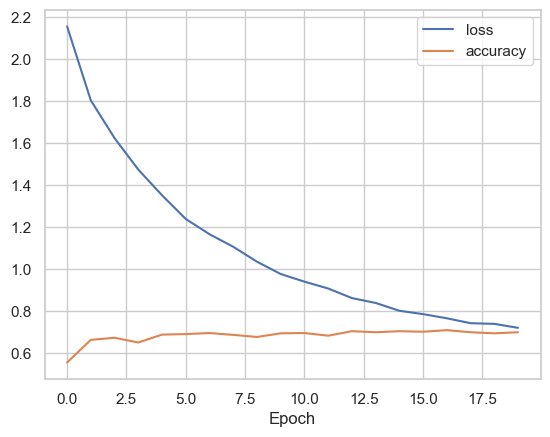

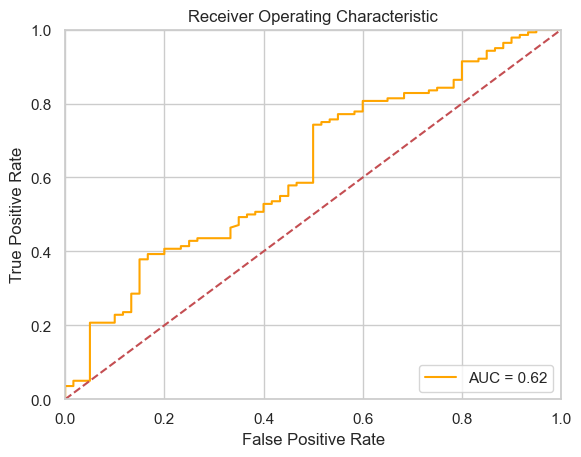

AUC: 0.6243452380952381
Best Threshold=0.643972, G-Mean=0.609

Accuracy: 0.67
Precision: 0.7761194029850746
Recall: 0.7428571428571429
F-Measure: 0.759124087591241
Epoch 1: Loss=1.9377, Accuracy=0.6662
Epoch 2: Loss=1.6707, Accuracy=0.7150
Epoch 3: Loss=1.4658, Accuracy=0.7375
Epoch 4: Loss=1.3221, Accuracy=0.7400
Epoch 5: Loss=1.1984, Accuracy=0.7175
Epoch 6: Loss=1.0842, Accuracy=0.7637
Epoch 7: Loss=1.0275, Accuracy=0.7487
Epoch 8: Loss=0.9548, Accuracy=0.7425
Epoch 9: Loss=0.9093, Accuracy=0.7325
Epoch 10: Loss=0.8496, Accuracy=0.7350
Epoch 11: Loss=0.8144, Accuracy=0.7450
Epoch 12: Loss=0.7754, Accuracy=0.7575
Epoch 13: Loss=0.7471, Accuracy=0.7550
Epoch 14: Loss=0.7177, Accuracy=0.7487
Epoch 15: Loss=0.6996, Accuracy=0.7400
Epoch 16: Loss=0.6782, Accuracy=0.7562
Epoch 17: Loss=0.6688, Accuracy=0.7425
Epoch 18: Loss=0.6498, Accuracy=0.7362
Epoch 19: Loss=0.6408, Accuracy=0.7500
Epoch 20: Loss=0.6189, Accuracy=0.7437
7/7 - 0s - loss: 0.5988 - accuracy: 0.7550 - 201ms/epoch - 29ms/s

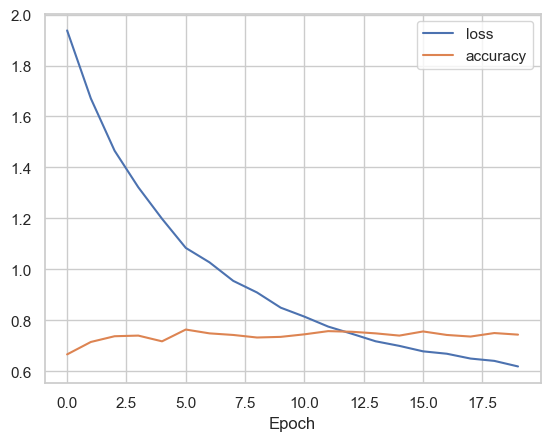

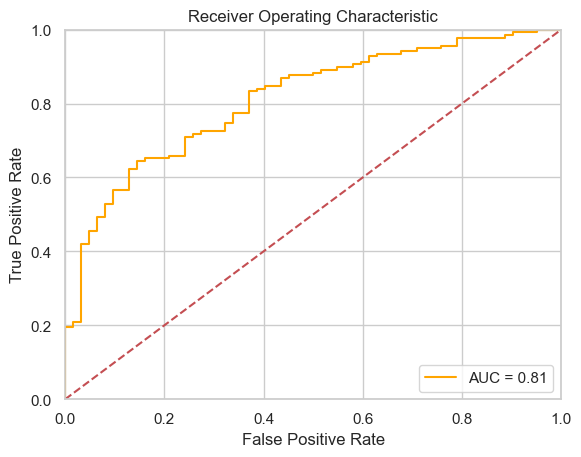

AUC: 0.8103085553997196
Best Threshold=0.580112, G-Mean=1.166

Accuracy: 0.775
Precision: 0.8163265306122449
Recall: 0.8695652173913043
F-Measure: 0.8421052631578948
Epoch 1: Loss=2.1471, Accuracy=0.5800
Epoch 2: Loss=1.8805, Accuracy=0.6513
Epoch 3: Loss=1.6852, Accuracy=0.6525
Epoch 4: Loss=1.5255, Accuracy=0.6875
Epoch 5: Loss=1.4157, Accuracy=0.6762
Epoch 6: Loss=1.3264, Accuracy=0.6637
Epoch 7: Loss=1.2228, Accuracy=0.6862
Epoch 8: Loss=1.1606, Accuracy=0.6900
Epoch 9: Loss=1.1045, Accuracy=0.6787
Epoch 10: Loss=1.0497, Accuracy=0.6925
Epoch 11: Loss=0.9920, Accuracy=0.6987
Epoch 12: Loss=0.9598, Accuracy=0.6975
Epoch 13: Loss=0.9114, Accuracy=0.6975
Epoch 14: Loss=0.8873, Accuracy=0.7000
Epoch 15: Loss=0.8593, Accuracy=0.6912
Epoch 16: Loss=0.8290, Accuracy=0.6950
Epoch 17: Loss=0.8082, Accuracy=0.6925
Epoch 18: Loss=0.7923, Accuracy=0.6950
Epoch 19: Loss=0.7786, Accuracy=0.6912
Epoch 20: Loss=0.7564, Accuracy=0.6925
7/7 - 0s - loss: 0.6811 - accuracy: 0.7550 - 201ms/epoch - 29ms

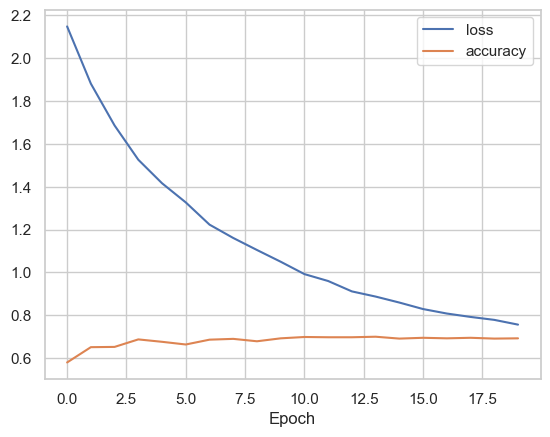

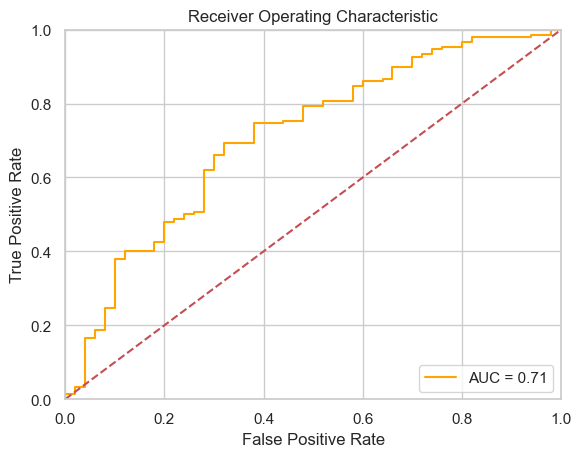

AUC: 0.7101333333333333
Best Threshold=0.669510, G-Mean=0.687

Accuracy: 0.69
Precision: 0.8666666666666667
Recall: 0.6933333333333334
F-Measure: 0.7703703703703704
Epoch 1: Loss=1.9661, Accuracy=0.6362
Epoch 2: Loss=1.5923, Accuracy=0.7237
Epoch 3: Loss=1.4113, Accuracy=0.7100
Epoch 4: Loss=1.2437, Accuracy=0.7425
Epoch 5: Loss=1.1191, Accuracy=0.7425
Epoch 6: Loss=1.0187, Accuracy=0.7387
Epoch 7: Loss=0.9487, Accuracy=0.7462
Epoch 8: Loss=0.8830, Accuracy=0.7450
Epoch 9: Loss=0.8342, Accuracy=0.7337
Epoch 10: Loss=0.7853, Accuracy=0.7600
Epoch 11: Loss=0.7585, Accuracy=0.7475
Epoch 12: Loss=0.7300, Accuracy=0.7475
Epoch 13: Loss=0.7037, Accuracy=0.7425
Epoch 14: Loss=0.6804, Accuracy=0.7512
Epoch 15: Loss=0.6608, Accuracy=0.7425
Epoch 16: Loss=0.6380, Accuracy=0.7512
Epoch 17: Loss=0.6293, Accuracy=0.7425
Epoch 18: Loss=0.6150, Accuracy=0.7437
Epoch 19: Loss=0.6032, Accuracy=0.7412
Epoch 20: Loss=0.5994, Accuracy=0.7500
7/7 - 0s - loss: 0.5785 - accuracy: 0.7700 - 210ms/epoch - 30ms/

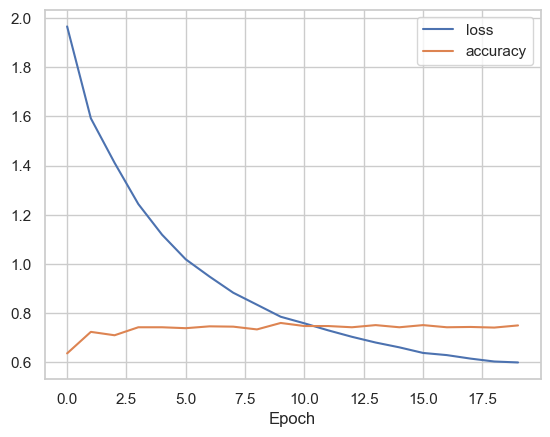

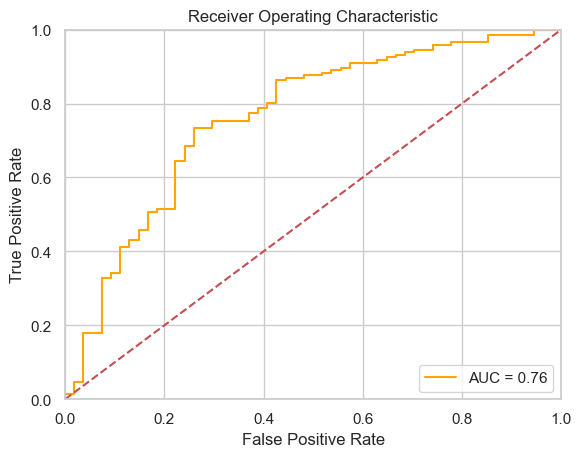

AUC: 0.7624302384576358
Best Threshold=0.553912, G-Mean=1.166

Accuracy: 0.785
Precision: 0.8456375838926175
Recall: 0.863013698630137
F-Measure: 0.8542372881355932
Epoch 1: Loss=2.1720, Accuracy=0.5813
Epoch 2: Loss=1.9016, Accuracy=0.6637
Epoch 3: Loss=1.7273, Accuracy=0.6775
Epoch 4: Loss=1.5710, Accuracy=0.6937
Epoch 5: Loss=1.4582, Accuracy=0.6887
Epoch 6: Loss=1.3464, Accuracy=0.6912
Epoch 7: Loss=1.2656, Accuracy=0.6937
Epoch 8: Loss=1.2096, Accuracy=0.6887
Epoch 9: Loss=1.1420, Accuracy=0.6937
Epoch 10: Loss=1.0761, Accuracy=0.7050
Epoch 11: Loss=1.0319, Accuracy=0.6775
Epoch 12: Loss=0.9854, Accuracy=0.7025
Epoch 13: Loss=0.9407, Accuracy=0.6925
Epoch 14: Loss=0.9147, Accuracy=0.7075
Epoch 15: Loss=0.8819, Accuracy=0.6925
Epoch 16: Loss=0.8536, Accuracy=0.7063
Epoch 17: Loss=0.8244, Accuracy=0.6975
Epoch 18: Loss=0.7928, Accuracy=0.7075
Epoch 19: Loss=0.7897, Accuracy=0.6975
Epoch 20: Loss=0.7664, Accuracy=0.7113
7/7 - 0s - loss: 0.7679 - accuracy: 0.6950 - 207ms/epoch - 30ms/

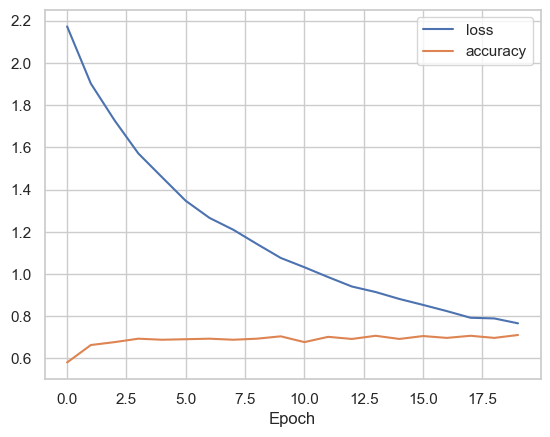

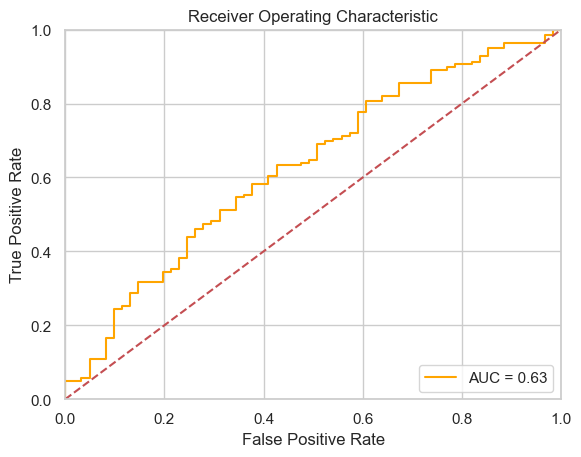

AUC: 0.6280221724259937
Best Threshold=0.705915, G-Mean=0.603

Accuracy: 0.615
Precision: 0.7719298245614035
Recall: 0.6330935251798561
F-Measure: 0.6956521739130435
Epoch 1: Loss=1.9514, Accuracy=0.6575
Epoch 2: Loss=1.6479, Accuracy=0.7250
Epoch 3: Loss=1.4240, Accuracy=0.7537
Epoch 4: Loss=1.2902, Accuracy=0.7337
Epoch 5: Loss=1.1589, Accuracy=0.7400
Epoch 6: Loss=1.0633, Accuracy=0.7587
Epoch 7: Loss=0.9880, Accuracy=0.7462
Epoch 8: Loss=0.9351, Accuracy=0.7500
Epoch 9: Loss=0.8707, Accuracy=0.7600
Epoch 10: Loss=0.8220, Accuracy=0.7512
Epoch 11: Loss=0.7808, Accuracy=0.7587
Epoch 12: Loss=0.7562, Accuracy=0.7475
Epoch 13: Loss=0.7195, Accuracy=0.7462
Epoch 14: Loss=0.7032, Accuracy=0.7450
Epoch 15: Loss=0.6706, Accuracy=0.7575
Epoch 16: Loss=0.6532, Accuracy=0.7487
Epoch 17: Loss=0.6340, Accuracy=0.7437
Epoch 18: Loss=0.6144, Accuracy=0.7662
Epoch 19: Loss=0.6144, Accuracy=0.7550
Epoch 20: Loss=0.6053, Accuracy=0.7550
7/7 - 0s - loss: 0.6564 - accuracy: 0.7200 - 239ms/epoch - 34ms

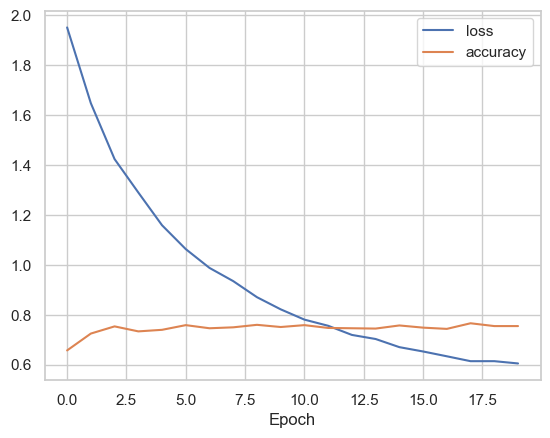

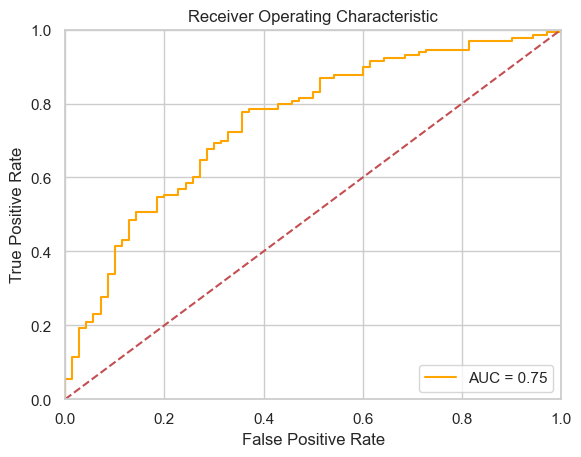

AUC: 0.7506593406593407
Best Threshold=0.521035, G-Mean=1.136

Accuracy: 0.735
Precision: 0.7583892617449665
Recall: 0.8692307692307693
F-Measure: 0.8100358422939069
Epoch 1: Loss=2.1627, Accuracy=0.5750
Epoch 2: Loss=1.8872, Accuracy=0.6538
Epoch 3: Loss=1.6899, Accuracy=0.6762
Epoch 4: Loss=1.5598, Accuracy=0.6875
Epoch 5: Loss=1.4257, Accuracy=0.7025
Epoch 6: Loss=1.3313, Accuracy=0.7012
Epoch 7: Loss=1.2515, Accuracy=0.6912
Epoch 8: Loss=1.1803, Accuracy=0.7063
Epoch 9: Loss=1.1128, Accuracy=0.7050
Epoch 10: Loss=1.0721, Accuracy=0.6837
Epoch 11: Loss=1.0132, Accuracy=0.7075
Epoch 12: Loss=0.9670, Accuracy=0.7050
Epoch 13: Loss=0.9364, Accuracy=0.6925
Epoch 14: Loss=0.9020, Accuracy=0.7075
Epoch 15: Loss=0.8636, Accuracy=0.7175
Epoch 16: Loss=0.8404, Accuracy=0.7012
Epoch 17: Loss=0.8236, Accuracy=0.7025
Epoch 18: Loss=0.7823, Accuracy=0.7088
Epoch 19: Loss=0.7720, Accuracy=0.7075
Epoch 20: Loss=0.7639, Accuracy=0.7125
7/7 - 0s - loss: 0.8051 - accuracy: 0.6650 - 219ms/epoch - 31ms

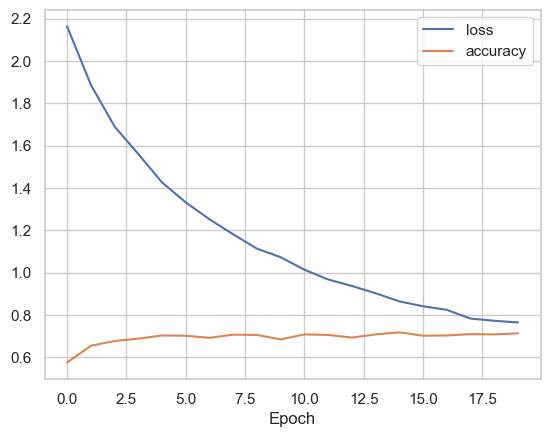

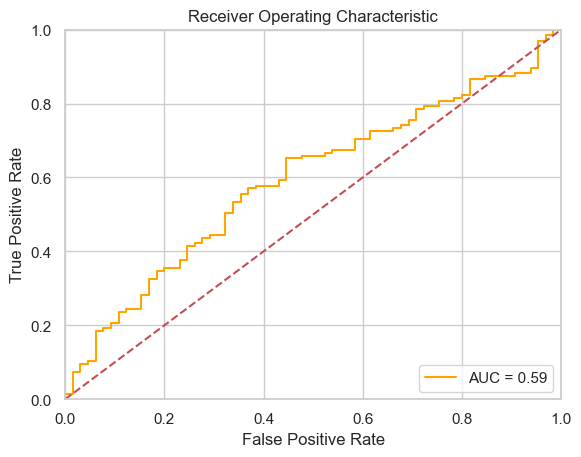

AUC: 0.5930484330484331
Best Threshold=0.700139, G-Mean=0.601

Accuracy: 0.62
Precision: 0.7521367521367521
Recall: 0.6518518518518519
F-Measure: 0.6984126984126984
Epoch 1: Loss=1.9681, Accuracy=0.6575
Epoch 2: Loss=1.6297, Accuracy=0.7387
Epoch 3: Loss=1.4393, Accuracy=0.7375
Epoch 4: Loss=1.2907, Accuracy=0.7387
Epoch 5: Loss=1.1695, Accuracy=0.7475
Epoch 6: Loss=1.0647, Accuracy=0.7487
Epoch 7: Loss=1.0025, Accuracy=0.7487
Epoch 8: Loss=0.9362, Accuracy=0.7400
Epoch 9: Loss=0.8829, Accuracy=0.7500
Epoch 10: Loss=0.8447, Accuracy=0.7562
Epoch 11: Loss=0.7956, Accuracy=0.7475
Epoch 12: Loss=0.7675, Accuracy=0.7487
Epoch 13: Loss=0.7381, Accuracy=0.7475
Epoch 14: Loss=0.7187, Accuracy=0.7612
Epoch 15: Loss=0.7024, Accuracy=0.7450
Epoch 16: Loss=0.6814, Accuracy=0.7500
Epoch 17: Loss=0.6564, Accuracy=0.7612
Epoch 18: Loss=0.6386, Accuracy=0.7612
Epoch 19: Loss=0.6398, Accuracy=0.7450
Epoch 20: Loss=0.6199, Accuracy=0.7550
7/7 - 0s - loss: 0.6344 - accuracy: 0.7300 - 245ms/epoch - 35ms/

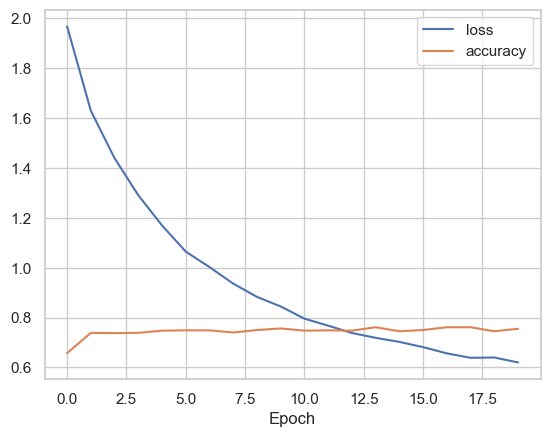

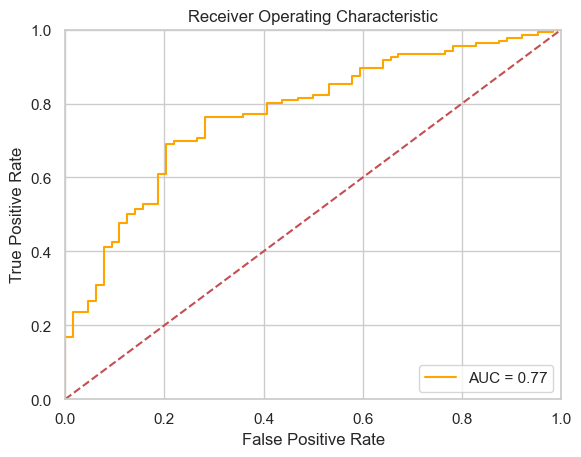

AUC: 0.7734375
Best Threshold=0.680526, G-Mean=1.146

Accuracy: 0.75
Precision: 0.8524590163934426
Recall: 0.7647058823529411
F-Measure: 0.8062015503875968
Epoch 1: Loss=2.1573, Accuracy=0.5737
Epoch 2: Loss=1.8526, Accuracy=0.6675
Epoch 3: Loss=1.6466, Accuracy=0.6887
Epoch 4: Loss=1.4915, Accuracy=0.6875
Epoch 5: Loss=1.3939, Accuracy=0.6862
Epoch 6: Loss=1.2784, Accuracy=0.7000
Epoch 7: Loss=1.2146, Accuracy=0.7063
Epoch 8: Loss=1.1320, Accuracy=0.7037
Epoch 9: Loss=1.0689, Accuracy=0.7150
Epoch 10: Loss=1.0176, Accuracy=0.7063
Epoch 11: Loss=0.9758, Accuracy=0.7075
Epoch 12: Loss=0.9262, Accuracy=0.7237
Epoch 13: Loss=0.9068, Accuracy=0.7037
Epoch 14: Loss=0.8674, Accuracy=0.7113
Epoch 15: Loss=0.8278, Accuracy=0.7113
Epoch 16: Loss=0.8231, Accuracy=0.7100
Epoch 17: Loss=0.7866, Accuracy=0.7075
Epoch 18: Loss=0.7747, Accuracy=0.7188
Epoch 19: Loss=0.7496, Accuracy=0.7138
Epoch 20: Loss=0.7365, Accuracy=0.7125
7/7 - 0s - loss: 0.7551 - accuracy: 0.6700 - 231ms/epoch - 33ms/step

Tes

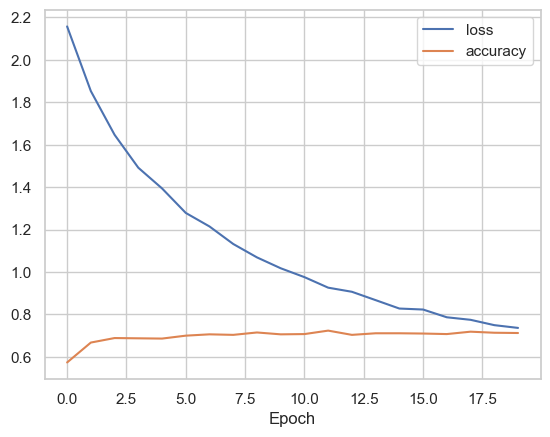

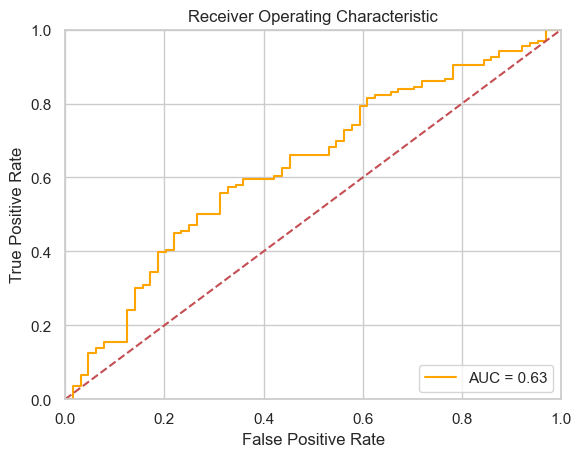

AUC: 0.6316636029411765
Best Threshold=0.695553, G-Mean=0.621

Accuracy: 0.605
Precision: 0.7878787878787878
Recall: 0.5735294117647058
F-Measure: 0.6638297872340425
Epoch 1: Loss=1.8583, Accuracy=0.6825
Epoch 2: Loss=1.5508, Accuracy=0.7312
Epoch 3: Loss=1.3516, Accuracy=0.7237
Epoch 4: Loss=1.1978, Accuracy=0.7400
Epoch 5: Loss=1.0737, Accuracy=0.7412
Epoch 6: Loss=0.9888, Accuracy=0.7287
Epoch 7: Loss=0.9149, Accuracy=0.7400
Epoch 8: Loss=0.8518, Accuracy=0.7412
Epoch 9: Loss=0.7926, Accuracy=0.7462
Epoch 10: Loss=0.7705, Accuracy=0.7462
Epoch 11: Loss=0.7379, Accuracy=0.7425
Epoch 12: Loss=0.7034, Accuracy=0.7437
Epoch 13: Loss=0.6714, Accuracy=0.7487
Epoch 14: Loss=0.6602, Accuracy=0.7500
Epoch 15: Loss=0.6425, Accuracy=0.7337
Epoch 16: Loss=0.6266, Accuracy=0.7500
Epoch 17: Loss=0.6088, Accuracy=0.7525
Epoch 18: Loss=0.5990, Accuracy=0.7437
Epoch 19: Loss=0.5910, Accuracy=0.7562
Epoch 20: Loss=0.5894, Accuracy=0.7437
7/7 - 0s - loss: 0.5790 - accuracy: 0.7700 - 252ms/epoch - 36ms

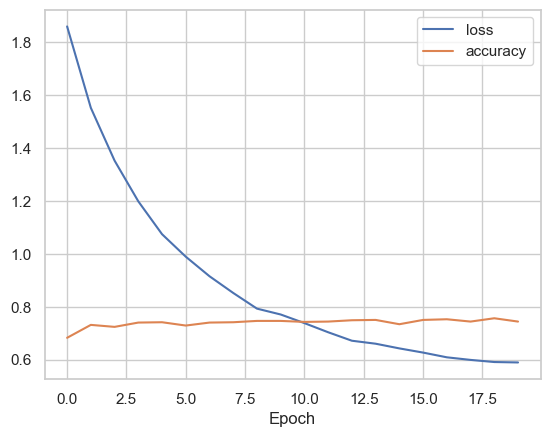

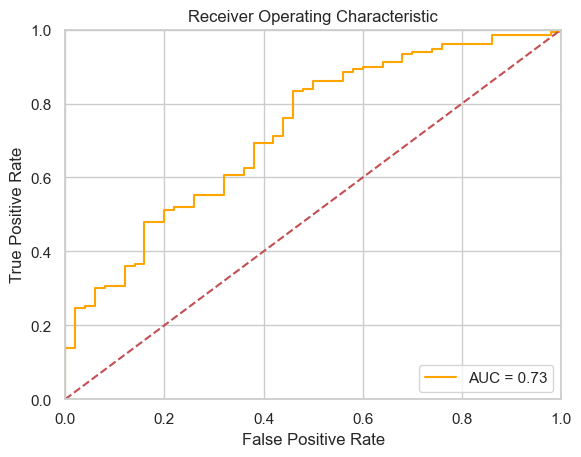

AUC: 0.7257333333333333
Best Threshold=0.546034, G-Mean=1.136

Accuracy: 0.77
Precision: 0.8376623376623377
Recall: 0.86
F-Measure: 0.8486842105263157


In [27]:
for (cen1_train_index, cen1_test_index), (cen2_train_index, cen2_test_index) in zip(
        kfold.split(client1_input_index, client1_target_index),
        kfold.split(client2_input_index, client2_target_index)):
  
  # index
  cen1_train_x_index = client1_input_index[cen1_train_index]
  cen2_train_x_index = client2_input_index[cen2_train_index]
  
  cen1_test_x_index = client1_input_index[cen1_test_index]
  cen2_test_x_index = client2_input_index[cen2_test_index]
  
  cen1_train_y_index = client1_target_index[cen1_train_index]
  cen2_train_y_index = client2_target_index[cen2_train_index]
  
  cen1_test_y_index = client1_target_index[cen1_test_index]
  cen2_test_y_index = client2_target_index[cen2_test_index]
  
  
  # define train,test x use index
  client1_train_x_k = client1_input[client1_input.index.isin(cen1_train_x_index)]
  client2_train_x_k = client2_input[client2_input.index.isin(cen2_train_x_index)]
  
  client1_test_x_k = client1_input[client1_input.index.isin(cen1_test_x_index)]
  client2_test_x_k = client2_input[client2_input.index.isin(cen2_test_x_index)]

  client1_train_y_k = client1_target[client1_target.index.isin(cen1_train_y_index)]
  client2_train_y_k = client2_target[client2_target.index.isin(cen2_train_y_index)]
  
  client1_test_y_k = client1_target[client1_target.index.isin(cen1_test_y_index)]
  client2_test_y_k = client2_target[client2_target.index.isin(cen2_test_y_index)]
  

  common_train_index_k = np.intersect1d(cen1_train_x_index,cen2_train_x_index)
  common_test_index_k = np.intersect1d(cen1_test_x_index,cen2_test_x_index)
  
  # ----------init cen_1
  normalizer_cen1 = normalize_data(client1_train_x_k.loc[common_train_index_k])
  model_cen1 = tf.keras.Sequential([
        normalizer_cen1,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])


  epoch_loss=[]
  epoch_acc=[]
  # custom callback
  class PrintMetricsCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          epoch_loss.append(logs["loss"])
          epoch_acc.append(logs["accuracy"])
          print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


  model_cen1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


  # fit1
  test_results = {}
  cen1_history = model_cen1.fit(client1_train_x_k, client1_train_y_k, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


  #evaluate
  test_loss, test_acc = model_cen1.evaluate(client1_test_x_k, client1_test_y_k, verbose=2)
  print('\nTest accuracy:', test_acc)


  # result
  cen1_pred_test= model_cen1.predict(client1_test_x_k)

  # plot loss
  plot_loss(epoch_loss, epoch_acc)
  # 計算roc,auc
  cen1_fpr_test, cen1_tpr_test, cen1_thresholds_test = roc_curve(client1_test_y_k, cen1_pred_test[:,1])
  auc_cen1 = auc(cen1_fpr_test, cen1_tpr_test)
  draw_roc_curve(cen1_fpr_test, cen1_tpr_test,auc=auc_cen1)
  print("AUC: {}".format(auc_cen1 ))

  # 計算threshold 值

  cen1_gmeans_test = np.sqrt(cen1_tpr_test * (1-cen1_fpr_test))
  cen1_ix_test = np.argmax(cen1_gmeans_test)
  best_threshold_cen1 = cen1_thresholds_test[cen1_ix_test]
  print('Best Threshold=%f, G-Mean=%.3f\n' % (cen1_thresholds_test[cen1_ix_test], cen1_gmeans_test[cen1_ix_test]))


  # probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

  plot_accuracy(cen1_pred_test,client1_test_y_k,best_threshold_cen1)
  cen1_pred_test_label = [1 if p >= best_threshold_cen1 else 0 for p in  cen1_pred_test[:,1]]
  # df['predict_cen1']=cen1_pred_test_label
  # df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')

# ---------------init cen_2
  normalizer_cen2 = normalize_data(client2_train_x_k.loc[common_train_index_k])
  model_cen2 = tf.keras.Sequential([
        normalizer_cen2,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])

  epoch_loss=[]
  epoch_acc=[]
  # custom callback
  class PrintMetricsCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          epoch_loss.append(logs["loss"])
          epoch_acc.append(logs["accuracy"])
          print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


  model_cen2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])


  # fit2
  test_results = {}
  cen2_history = model_cen2.fit(client2_train_x_k, client2_train_y_k, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


  #evaluate
  test_loss, test_acc = model_cen2.evaluate(client2_test_x_k, client2_test_y_k, verbose=2)
  print('\nTest accuracy:', test_acc)


  # result
  cen2_pred_test= model_cen2.predict(client2_test_x_k)

  # plot loss
  plot_loss(epoch_loss, epoch_acc)

  # 計算roc,auc
  cen2_fpr_test, cen2_tpr_test, cen2_thresholds_test = roc_curve(client2_test_y_k, cen2_pred_test[:,1])
  auc_cen2 = auc(cen2_fpr_test, cen2_tpr_test)
  draw_roc_curve(cen2_fpr_test, cen2_tpr_test,auc=auc_cen2)
  print("AUC: {}".format(auc_cen2 ))

  # 計算threshold 值

  cen2_gmeans_test = np.sqrt(cen2_tpr_test * (2-cen2_fpr_test))
  cen2_ix_test = np.argmax(cen2_gmeans_test)
  best_threshold_cen2 = cen2_thresholds_test[cen2_ix_test]
  print('Best Threshold=%f, G-Mean=%.3f\n' % (cen2_thresholds_test[cen2_ix_test], cen2_gmeans_test[cen2_ix_test]))

  # save result
  # probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
  plot_accuracy(cen2_pred_test,client2_test_y_k,best_threshold_cen2)
  cen2_pred_test_label = [1 if p >= best_threshold_cen2 else 0 for p in  cen2_pred_test[:,1]]
  # df['predict_cen2']=cen2_pred_test_label
  # df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')